In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

import random
import matplotlib.gridspec as gridspec

# 模型参数
latent_dim = 30
categorical_dim = 10  # one-of-K vector
temp_min = 0.3
ANNEAL_RATE = 0.003 # og: 0.00003
initial_temperature = 1.0
final_temperature = 0.3

# 训练参数
batch_size = 100
epochs = 20 # og: 10
temp = 1.0
seed = 1
log_interval = 10
hard = False
cuda = torch.cuda.is_available()

# 设置随机种子
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

# 数据加载
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_MNIST', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_MNIST', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

# Gumbel Softmax 相关函数
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    y = gumbel_softmax_sample(logits, temperature)
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(-1, latent_dim * categorical_dim)


# VAE模型定义
class CVAE(nn.Module):
    def __init__(self, temp):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        q = self.encode(x.view(-1, 784))
        q_y = q.view(q.size(0), latent_dim, categorical_dim)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decode(z), F.softmax(q_y, dim=-1).reshape(*q.size())
model = CVAE(temp)

# 损失函数
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False) / x.shape[0]
    # use pytorch kl_divergence to calculate KL divergence between qy's distribution on categorical_dim and uniform distribution
    KLD = torch.nn.functional.kl_div(qy.log(), torch.Tensor([1.0 / categorical_dim]).repeat(qy.shape)) * latent_dim * categorical_dim

    return BCE + KLD

# 对测试集按标签分类
def classify_test_set(test_loader):
    images_by_label = {i: [] for i in range(10)}
    with torch.no_grad():
        for data, labels in test_loader:
            for i in range(len(labels)):
                label = labels[i].item()
                images_by_label[label].append(data[i])
    return images_by_label
images_by_label = classify_test_set(test_loader)

# 重构并绘图
def reconstruct_and_plot(model, images_by_label, temp, hard):
    model.eval()
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))

    for label in range(10):
        image = random.choice(images_by_label[label])
        image = image.unsqueeze(0)

        if cuda:
            image = image.cuda()

        recon_image, _ = model(image, temp, hard)
        recon_image = recon_image.view(1, 28, 28).cpu().detach().numpy()

        axes[0, label].imshow(image[0, 0].cpu(), cmap='gray')
        axes[0, label].axis('off')
        axes[1, label].imshow(recon_image[0], cmap='gray')
        axes[1, label].axis('off')
    plt.tight_layout()
    plt.show()


Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Epoch 20: 100%|██████████| 600/600 [00:19<00:00, 30.23it/s, Loss=121]


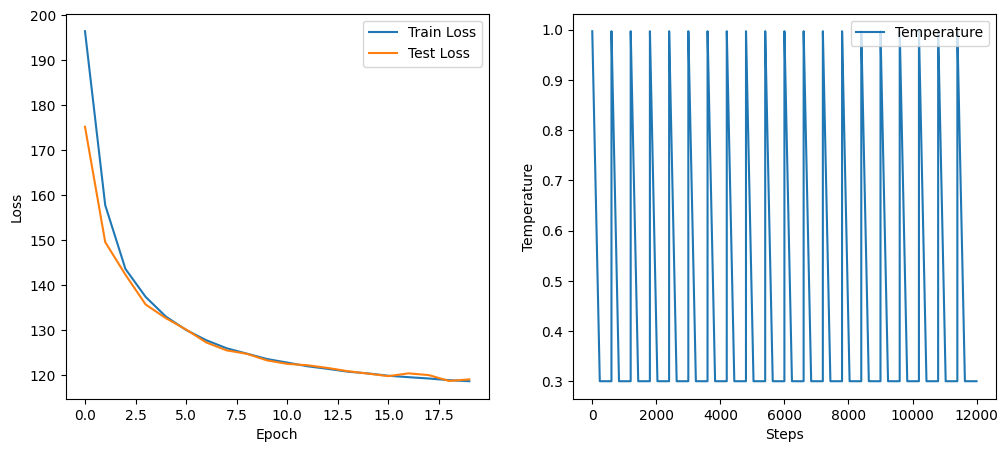

In [2]:
# 存储损失和温度的列表
train_losses = []
test_losses = []
temperatures = []

# 修改训练函数以记录损失和温度
def train(model, train_loader, optimizer, epoch, temp, hard, log_interval):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (data, _) in enumerate(pbar):
        if cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, qy = model(data, temp, hard)
        loss = loss_function(recon_batch, data, qy)
        loss.backward()
        train_loss += loss.item() * len(data)
        optimizer.step()
        temp -= ANNEAL_RATE
        temp = np.maximum(temp, final_temperature)
        temperatures.append(temp)
        if batch_idx % log_interval == 0:
            pbar.set_postfix({"Loss": loss.item()})
    
    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    # print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_loss))

# 修改测试函数以记录损失
def test(model, test_loader, epoch, temp, hard):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if cuda:
                data = data.cuda()
            recon_batch, qy = model(data, temp, hard)
            test_loss += loss_function(recon_batch, data, qy).item() * len(data)
            if i % 100 == 1:
                temp = np.maximum(temp * np.exp(-ANNEAL_RATE * i), temp_min)
    
    avg_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_loss)
    # print('====> Test set loss: {:.4f}'.format(avg_loss))

# 在主函数中运行训练和测试
def run():
    if cuda:
        model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch, temp, hard, log_interval)
        test(model, test_loader, epoch, temp, hard)
        # reconstruct_and_plot(model, images_by_label, temp, hard)

    # 绘制损失和温度
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(temperatures, label='Temperature')
    plt.xlabel('Steps')
    plt.ylabel('Temperature')
    plt.legend()
    
    plt.show()

if __name__ == '__main__':
    run()

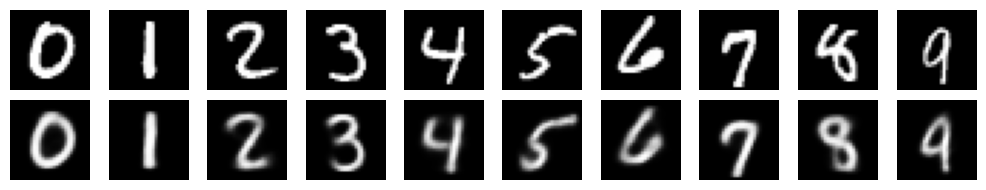

In [3]:
reconstruct_and_plot(model, images_by_label, temp, hard)

/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


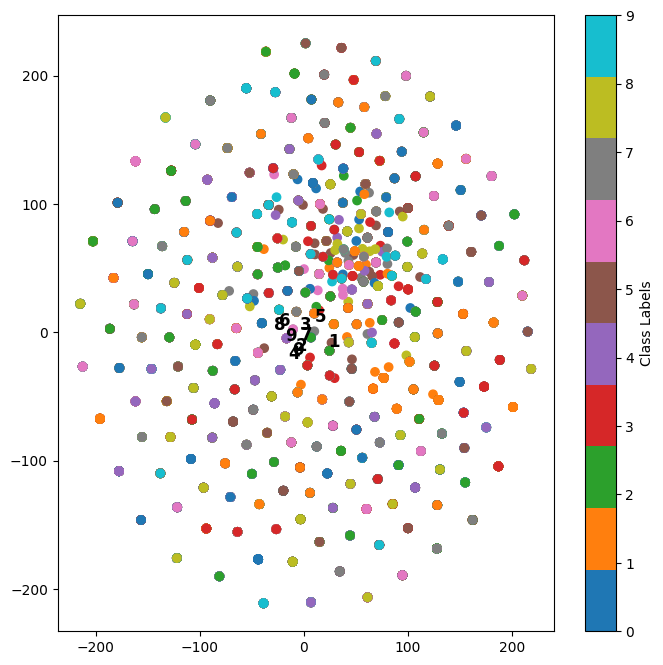

In [4]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_tsne(model, test_loader, temp, hard):
    # 初始化
    latent_vectors = torch.empty(0, latent_dim * categorical_dim)
    Y = torch.empty(0, dtype=torch.long)

    # 将数据集发送到编码器
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, 784)
            if cuda:
                x = x.cuda()
            logits = model.encode(x)
            z = gumbel_softmax(logits, temp, hard)
            latent_vectors = torch.cat([latent_vectors, z.cpu()])
            Y = torch.cat([Y, y])

    # 将潜在向量转换为numpy数组
    latent_vectors = latent_vectors.cpu().numpy()
    Y = Y.cpu().numpy()

    # 在潜在向量上运行t-SNE以获得2D嵌入
    tsne = TSNE(n_components=2)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # 绘制2D嵌入
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
    plt.colorbar(scatter, label='Class Labels')
    for i in range(10): # 10个类别
        centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
        plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    plt.show()

visualize_tsne(model, test_loader, temp=0.5, hard=True)


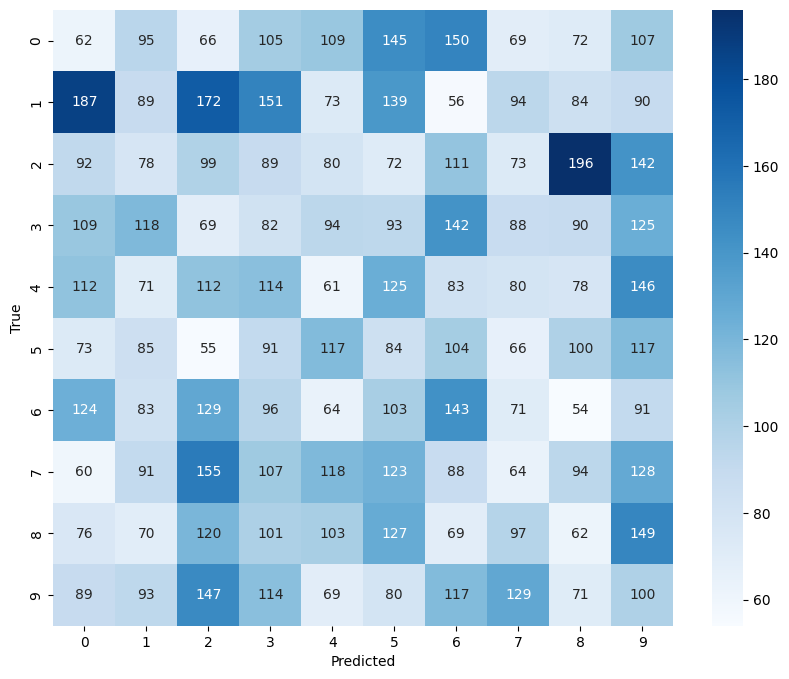

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def visualize_confusion_matrix(model, test_loader, temp, hard):
    # 初始化
    predicted_labels = []
    Y_true = []

    # 将数据集发送到编码器并获取预测标签
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, 784)
            if cuda:
                x = x.cuda()
            logits = model.encode(x)
            q_y = gumbel_softmax(logits, temp, hard)
            q_y = q_y.view(q_y.size(0), latent_dim, categorical_dim).cpu().numpy()
            predicted_label = q_y.mean(axis=1).argmax(axis=-1) # 获取最可能的标签
            predicted_labels.extend(predicted_label)
            Y_true.extend(y.numpy())

    # 计算混淆矩阵
    cm = confusion_matrix(Y_true, predicted_labels)

    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 可视化混淆矩阵
visualize_confusion_matrix(model, test_loader, temp=0.1, hard=True)
